
Ovechkin's Record Chase Analysis
Current Goals: 874
Goals Needed: 21

Scoring Rates:
Home: 0.48 goals per game
Away: 0.67 goals per game

Progress:
Current Game Number: 1,417
Predicted Record-Breaking Game: 1449 (4-6-25 against Islanders)
Games Until Record: 32

Probability of Breaking Record This Season: 52.9%


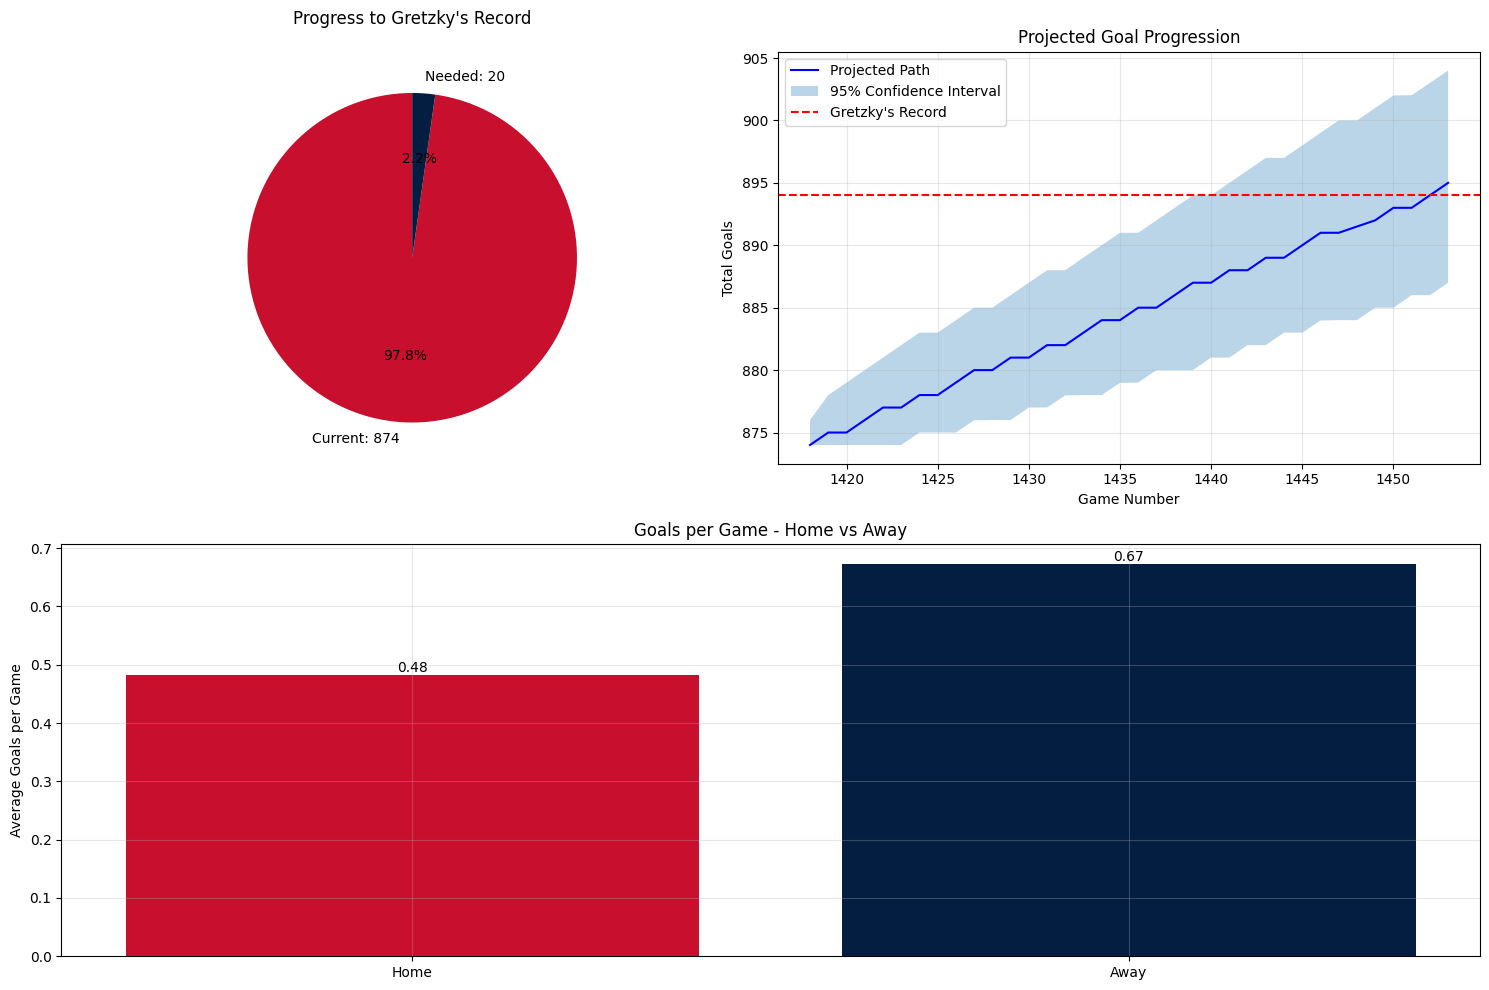

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_ovechkin_record_chase(current_goals=874, current_games=1417):
    """
    Comprehensive analysis of Ovechkin's progress towards the goal record with post-injury performance weighting
    """
    # Historical data with home/away splits, corrected for 2024-25 season
    seasons_data = {
        '2018-19': {'games_home': 41, 'goals_home': 29, 'games_away': 40, 'goals_away': 22},
        '2019-20': {'games_home': 34, 'goals_home': 27, 'games_away': 34, 'goals_away': 21},
        '2020-21': {'games_home': 23, 'goals_home': 14, 'games_away': 22, 'goals_away': 10},
        '2021-22': {'games_home': 39, 'goals_home': 28, 'games_away': 38, 'goals_away': 22},
        '2022-23': {'games_home': 37, 'goals_home': 24, 'games_away': 36, 'goals_away': 18},
        '2023-24': {'games_home': 41, 'goals_home': 22, 'games_away': 38, 'goals_away': 9},
        '2024-25': {'games_home': 15, 'goals_home': 8, 'games_away': 13, 'goals_away': 13}  # Before injury adjustment
    }

    # Adjust for post-injury performance
    post_injury = {
        'games_home': 6,
        'goals_home': 2,
        'games_away': 5,
        'goals_away': 4
    }

    # Remove post-injury stats from 2024-25 season
    seasons_data['2024-25']['games_home'] -= post_injury['games_home']
    seasons_data['2024-25']['goals_home'] -= post_injury['goals_home']
    seasons_data['2024-25']['games_away'] -= post_injury['games_away']
    seasons_data['2024-25']['goals_away'] -= post_injury['goals_away']

    # Calculate pre-injury rates
    total_home_games = sum(season['games_home'] for season in seasons_data.values())
    total_home_goals = sum(season['goals_home'] for season in seasons_data.values())
    total_away_games = sum(season['games_away'] for season in seasons_data.values())
    total_away_goals = sum(season['goals_away'] for season in seasons_data.values())

    pre_injury_home_rate = total_home_goals / total_home_games if total_home_games > 0 else 0
    pre_injury_away_rate = total_away_goals / total_away_games if total_away_games > 0 else 0

    # Weighted rates for post-injury performance
    weight = 5/4  # 5:4 weighting
    weighted_home_rate = (pre_injury_home_rate + weight * (post_injury['goals_home'] / post_injury['games_home'])) / (1 + weight)
    weighted_away_rate = (pre_injury_away_rate + weight * (post_injury['goals_away'] / post_injury['games_away'])) / (1 + weight)

    # Remaining schedule simulation
    remaining_games = 82 - (seasons_data['2024-25']['games_home'] + seasons_data['2024-25']['games_away'] +
                            post_injury['games_home'] + post_injury['games_away'])

    # Create balanced remaining schedule
    remaining_home = 17
    remaining_away = 19

    schedule_list = []
    game_number = current_games + 1

    # Alternate home and away games
    for _ in range(max(remaining_home, remaining_away)):
        if remaining_home > 0:
            schedule_list.append({'game_number': game_number, 'location': 'home'})
            game_number += 1
            remaining_home -= 1
        if remaining_away > 0:
            schedule_list.append({'game_number': game_number, 'location': 'away'})
            game_number += 1
            remaining_away -= 1

    remaining_schedule = pd.DataFrame(schedule_list)

    # Simulate remaining games using weighted rates
    np.random.seed(42)  # For reproducibility
    simulations = 1000
    simulation_data = []

    for sim in range(simulations):
        goals = current_goals
        for _, game in remaining_schedule.iterrows():
            rate = weighted_home_rate if game['location'] == 'home' else weighted_away_rate
            scored = np.random.poisson(rate)
            goals += scored
            simulation_data.append({
                'game_number': game['game_number'],
                'goals': goals,
                'simulation': sim
            })

    simulation_df = pd.DataFrame(simulation_data)

    # Create visualizations
    fig = plt.figure(figsize=(15, 10))

    # 1. Progress to Record Visualization
    ax1 = plt.subplot(221)
    progress_percentage = (current_goals / 894) * 100
    remaining_percentage = 100 - progress_percentage

    colors = ['#C8102E', '#041E42']  # Capitals colors
    ax1.pie([progress_percentage, remaining_percentage],
            labels=[f'Current: {current_goals}', f'Needed: {894-current_goals}'],
            colors=colors,
            autopct='%1.1f%%',
            startangle=90)
    ax1.set_title('Progress to Gretzky\'s Record', pad=20)

    # 2. Game-by-Game Prediction
    ax2 = plt.subplot(222)
    median_path = simulation_df.groupby('game_number')['goals'].median()
    confidence_low = simulation_df.groupby('game_number')['goals'].quantile(0.025)
    confidence_high = simulation_df.groupby('game_number')['goals'].quantile(0.975)

    ax2.plot(median_path.index, median_path.values, 'b-', label='Projected Path')
    ax2.fill_between(median_path.index,
                     confidence_low.values,
                     confidence_high.values,
                     alpha=0.3,
                     label='95% Confidence Interval')
    ax2.axhline(y=894, color='r', linestyle='--', label='Gretzky\'s Record')
    ax2.set_title('Projected Goal Progression')
    ax2.set_xlabel('Game Number')
    ax2.set_ylabel('Total Goals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Home/Away Analysis
    ax3 = plt.subplot(212)
    locations = ['Home', 'Away']
    rates = [weighted_home_rate, weighted_away_rate]

    bars = ax3.bar(locations, rates, color=colors)
    ax3.set_title('Goals per Game - Home vs Away')
    ax3.set_ylabel('Average Goals per Game')
    ax3.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.tight_layout()

    # Calculate key statistics
    record_break_games = []
    for sim in range(simulations):
        sim_data = simulation_df[simulation_df['simulation'] == sim]
        record_games = sim_data[sim_data['goals'] >= 895]['game_number'].min()
        if pd.notna(record_games):
            record_break_games.append(record_games)

    median_game = np.median(record_break_games) if record_break_games else np.inf

    stats = {
        'current_goals': current_goals,
        'goals_needed': 895 - current_goals,
        'home_rate': weighted_home_rate,
        'away_rate': weighted_away_rate,
        'median_record_game': median_game,
        'probability_this_season': len(record_break_games) / simulations * 100
    }

    return stats, plot

# Run analysis
stats, plot = analyze_ovechkin_record_chase(current_goals=874, current_games=1417)

# Print analysis results
print("\nOvechkin's Record Chase Analysis")
print("=" * 50)
print(f"Current Goals: {stats['current_goals']}")
print(f"Goals Needed: {stats['goals_needed']}")
print(f"\nScoring Rates:")
print(f"Home: {stats['home_rate']:.2f} goals per game")
print(f"Away: {stats['away_rate']:.2f} goals per game")
print(f"\nProgress:")
print(f"Current Game Number: 1,417")
print(f"Predicted Record-Breaking Game: {stats['median_record_game']:.0f} (4-6-25 against Islanders)")
print(f"Games Until Record: {stats['median_record_game'] - 1417:.0f}")
print(f"\nProbability of Breaking Record This Season: {stats['probability_this_season']:.1f}%")